# Базовая U-Net на Луне

In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)
        
        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
    
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])

In [2]:
# Путь к данным
DATA_ROOT = "../data/MOON_SEGMENTATION_BINARY/"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 64
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 2
Батчей в val: 1


Размер батча изображений: torch.Size([64, 3, 128, 128])
Размер батча масок: torch.Size([64, 128, 128])


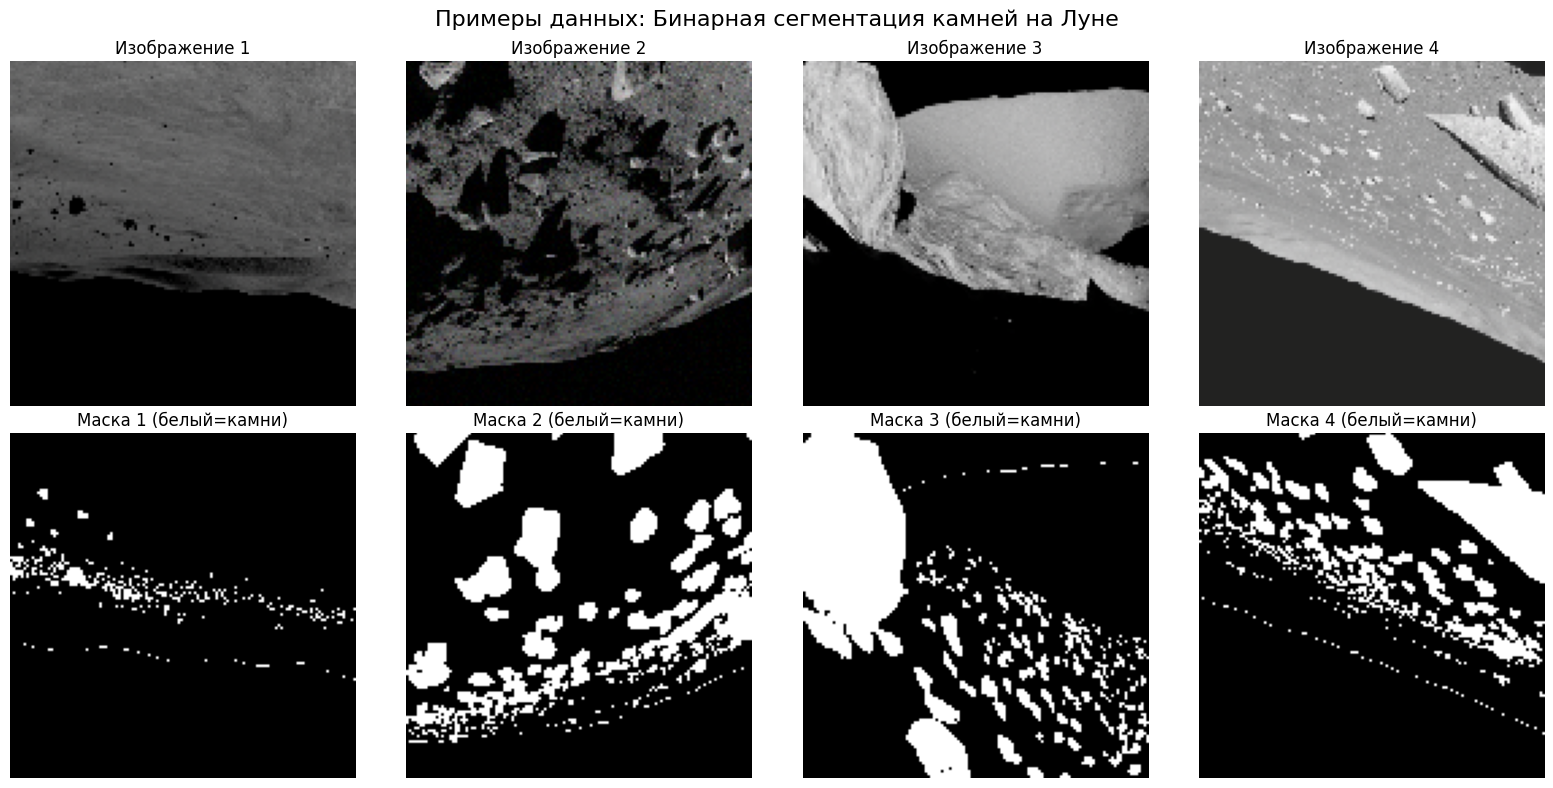

In [3]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

In [4]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

In [5]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

        self.sigmoid = nn.Sigmoid()

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        
        return output


model = UNet(in_channels=3, out_channels=1, features=[19, 38, 76, 152])

test_input = torch.randn(1, 3, 256, 256)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 2,740,276
Уровней encoder: 4
Конфигурация каналов: [19, 38, 76, 152]
   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])


In [6]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(train_loader, desc="Training")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

        running_loss += loss.item()
        running_dice += dice
        running_iou += iou
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)

    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, val_loader, criterion, device):

    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })
    
    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=.5, dice_weight=1.25)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Планировщик learning rate (уменьшаем lr при плато)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5, 
    patience=6, 
)

NUM_EPOCHS = 25

history_base = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='./training_results/2.Segmentation/Baseline/best_moon_unet.pth'
)

  Используем устройство: cpu
Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
Эпоха 1/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, loss=1.3982, dice=0.1781, iou=0.0977, acc=0.0977]



 Результаты эпохи 1:
  Train - Loss: 1.3722, Dice: 0.1699, IoU: 0.0937
  Val   - Loss: 1.3982, Dice: 0.1781, IoU: 0.0977, Acc: 0.0977
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.1781
Эпоха 2/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, loss=1.3959, dice=0.1824, iou=0.1003, acc=0.1319]



 Результаты эпохи 2:
  Train - Loss: 1.3256, Dice: 0.2937, IoU: 0.1723
  Val   - Loss: 1.3959, Dice: 0.1824, IoU: 0.1003, Acc: 0.1319
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.1824
Эпоха 3/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, loss=1.3854, dice=0.2397, iou=0.1362, acc=0.8976]



 Результаты эпохи 3:
  Train - Loss: 1.3241, Dice: 0.3041, IoU: 0.1795
  Val   - Loss: 1.3854, Dice: 0.2397, IoU: 0.1362, Acc: 0.8976
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.2397
Эпоха 4/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, loss=1.3694, dice=0.0117, iou=0.0059, acc=0.9026]



 Результаты эпохи 4:
  Train - Loss: 1.2870, Dice: 0.3409, IoU: 0.2055
  Val   - Loss: 1.3694, Dice: 0.0117, IoU: 0.0059, Acc: 0.9026
  LR: 0.001000
Эпоха 5/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, loss=1.3505, dice=0.0017, iou=0.0009, acc=0.9023]



 Результаты эпохи 5:
  Train - Loss: 1.2588, Dice: 0.3549, IoU: 0.2158
  Val   - Loss: 1.3505, Dice: 0.0017, IoU: 0.0009, Acc: 0.9023
  LR: 0.001000
Эпоха 6/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s, loss=1.3331, dice=0.0016, iou=0.0008, acc=0.9023]



 Результаты эпохи 6:
  Train - Loss: 1.2752, Dice: 0.3343, IoU: 0.2009
  Val   - Loss: 1.3331, Dice: 0.0016, IoU: 0.0008, Acc: 0.9023
  LR: 0.001000
Эпоха 7/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, loss=1.3175, dice=0.0017, iou=0.0008, acc=0.9023]



 Результаты эпохи 7:
  Train - Loss: 1.2520, Dice: 0.3517, IoU: 0.2134
  Val   - Loss: 1.3175, Dice: 0.0017, IoU: 0.0008, Acc: 0.9023
  LR: 0.001000
Эпоха 8/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s, loss=1.3020, dice=0.0029, iou=0.0015, acc=0.9024]



 Результаты эпохи 8:
  Train - Loss: 1.2287, Dice: 0.3803, IoU: 0.2349
  Val   - Loss: 1.3020, Dice: 0.0029, IoU: 0.0015, Acc: 0.9024
  LR: 0.001000
Эпоха 9/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=1.2874, dice=0.0044, iou=0.0022, acc=0.9024]



 Результаты эпохи 9:
  Train - Loss: 1.2331, Dice: 0.3714, IoU: 0.2281
  Val   - Loss: 1.2874, Dice: 0.0044, IoU: 0.0022, Acc: 0.9024
  LR: 0.001000
Эпоха 10/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s, loss=1.2791, dice=0.0061, iou=0.0031, acc=0.9025]



 Результаты эпохи 10:
  Train - Loss: 1.2464, Dice: 0.3732, IoU: 0.2296
  Val   - Loss: 1.2791, Dice: 0.0061, IoU: 0.0031, Acc: 0.9025
  LR: 0.000500
Эпоха 11/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, loss=1.2739, dice=0.0128, iou=0.0064, acc=0.9027]



 Результаты эпохи 11:
  Train - Loss: 1.2144, Dice: 0.4063, IoU: 0.2551
  Val   - Loss: 1.2739, Dice: 0.0128, IoU: 0.0064, Acc: 0.9027
  LR: 0.000500
Эпоха 12/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, loss=1.2661, dice=0.0346, iou=0.0176, acc=0.9037]



 Результаты эпохи 12:
  Train - Loss: 1.2149, Dice: 0.3815, IoU: 0.2357
  Val   - Loss: 1.2661, Dice: 0.0346, IoU: 0.0176, Acc: 0.9037
  LR: 0.000500
Эпоха 13/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, loss=1.2565, dice=0.0824, iou=0.0430, acc=0.9056]



 Результаты эпохи 13:
  Train - Loss: 1.1871, Dice: 0.4516, IoU: 0.2945
  Val   - Loss: 1.2565, Dice: 0.0824, IoU: 0.0430, Acc: 0.9056
  LR: 0.000500
Эпоха 14/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, loss=1.2427, dice=0.1571, iou=0.0852, acc=0.9086]



 Результаты эпохи 14:
  Train - Loss: 1.1981, Dice: 0.4333, IoU: 0.2774
  Val   - Loss: 1.2427, Dice: 0.1571, IoU: 0.0852, Acc: 0.9086
  LR: 0.000500
Эпоха 15/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s, loss=1.2290, dice=0.2266, iou=0.1278, acc=0.9107]



 Результаты эпохи 15:
  Train - Loss: 1.2111, Dice: 0.4192, IoU: 0.2654
  Val   - Loss: 1.2290, Dice: 0.2266, IoU: 0.1278, Acc: 0.9107
  LR: 0.000500
Эпоха 16/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, loss=1.2200, dice=0.2639, iou=0.1520, acc=0.9108]



 Результаты эпохи 16:
  Train - Loss: 1.1899, Dice: 0.4284, IoU: 0.2728
  Val   - Loss: 1.2200, Dice: 0.2639, IoU: 0.1520, Acc: 0.9108
  LR: 0.000500
  Сохранена лучшая модель! Dice: 0.2639
Эпоха 17/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, loss=1.2096, dice=0.3172, iou=0.1885, acc=0.9128]



 Результаты эпохи 17:
  Train - Loss: 1.1888, Dice: 0.4349, IoU: 0.2783
  Val   - Loss: 1.2096, Dice: 0.3172, IoU: 0.1885, Acc: 0.9128
  LR: 0.000500
  Сохранена лучшая модель! Dice: 0.3172
Эпоха 18/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s, loss=1.1869, dice=0.4080, iou=0.2563, acc=0.9155]



 Результаты эпохи 18:
  Train - Loss: 1.1851, Dice: 0.4278, IoU: 0.2722
  Val   - Loss: 1.1869, Dice: 0.4080, IoU: 0.2563, Acc: 0.9155
  LR: 0.000500
  Сохранена лучшая модель! Dice: 0.4080
Эпоха 19/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s, loss=1.1876, dice=0.3874, iou=0.2403, acc=0.9129]



 Результаты эпохи 19:
  Train - Loss: 1.2011, Dice: 0.4082, IoU: 0.2565
  Val   - Loss: 1.1876, Dice: 0.3874, IoU: 0.2403, Acc: 0.9129
  LR: 0.000500
Эпоха 20/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s, loss=1.1647, dice=0.4622, iou=0.3006, acc=0.9112]



 Результаты эпохи 20:
  Train - Loss: 1.1754, Dice: 0.4431, IoU: 0.2846
  Val   - Loss: 1.1647, Dice: 0.4622, IoU: 0.3006, Acc: 0.9112
  LR: 0.000500
  Сохранена лучшая модель! Dice: 0.4622
Эпоха 21/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, loss=1.1456, dice=0.5052, iou=0.3379, acc=0.9040]



 Результаты эпохи 21:
  Train - Loss: 1.1721, Dice: 0.4430, IoU: 0.2851
  Val   - Loss: 1.1456, Dice: 0.5052, IoU: 0.3379, Acc: 0.9040
  LR: 0.000500
  Сохранена лучшая модель! Dice: 0.5052
Эпоха 22/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, loss=1.1450, dice=0.5031, iou=0.3361, acc=0.9008]



 Результаты эпохи 22:
  Train - Loss: 1.2149, Dice: 0.3850, IoU: 0.2391
  Val   - Loss: 1.1450, Dice: 0.5031, IoU: 0.3361, Acc: 0.9008
  LR: 0.000500
Эпоха 23/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s, loss=1.1441, dice=0.5057, iou=0.3384, acc=0.9041]



 Результаты эпохи 23:
  Train - Loss: 1.1835, Dice: 0.4347, IoU: 0.2779
  Val   - Loss: 1.1441, Dice: 0.5057, IoU: 0.3384, Acc: 0.9041
  LR: 0.000500
  Сохранена лучшая модель! Dice: 0.5057
Эпоха 24/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, loss=1.1495, dice=0.4888, iou=0.3234, acc=0.9055]



 Результаты эпохи 24:
  Train - Loss: 1.2048, Dice: 0.4029, IoU: 0.2528
  Val   - Loss: 1.1495, Dice: 0.4888, IoU: 0.3234, Acc: 0.9055
  LR: 0.000500
Эпоха 25/25


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, loss=1.1482, dice=0.4752, iou=0.3116, acc=0.9020]


 Результаты эпохи 25:
  Train - Loss: 1.1922, Dice: 0.4033, IoU: 0.2538
  Val   - Loss: 1.1482, Dice: 0.4752, IoU: 0.3116, Acc: 0.9020
  LR: 0.000500
Лучший Val Dice: 0.5057


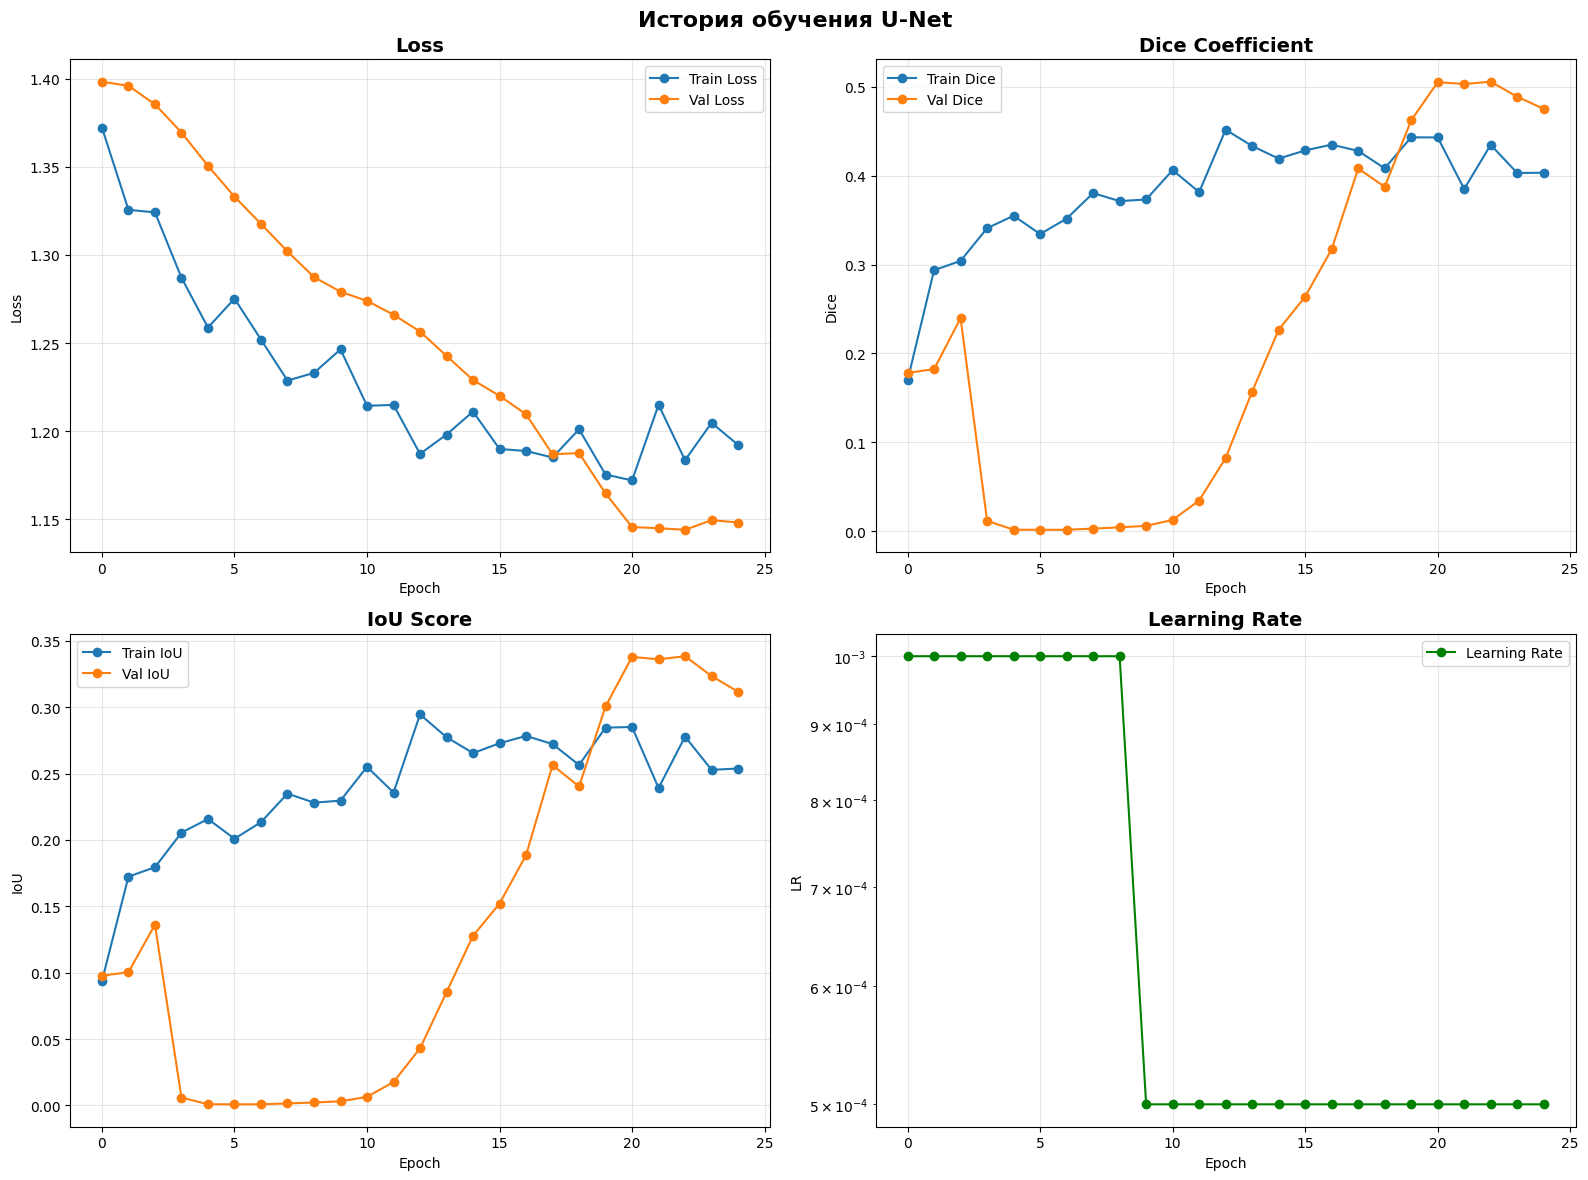

Сохранено в ./training_results/2.Segmentation/Baseline
Train Loss: 1.1922
Val Loss: 1.1482
Train Dice: 0.4033
Val Dice: 0.4752
Train IoU: 0.2538
Val IoU: 0.3116
Val Accuracy: 0.9020


In [16]:
from utils import *
plot_training_history(history_base, save_path='./training_results/2.Segmentation/Baseline')

Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
Эпоха: 23
Val Dice: 0.5057
Val IoU: 0.3384


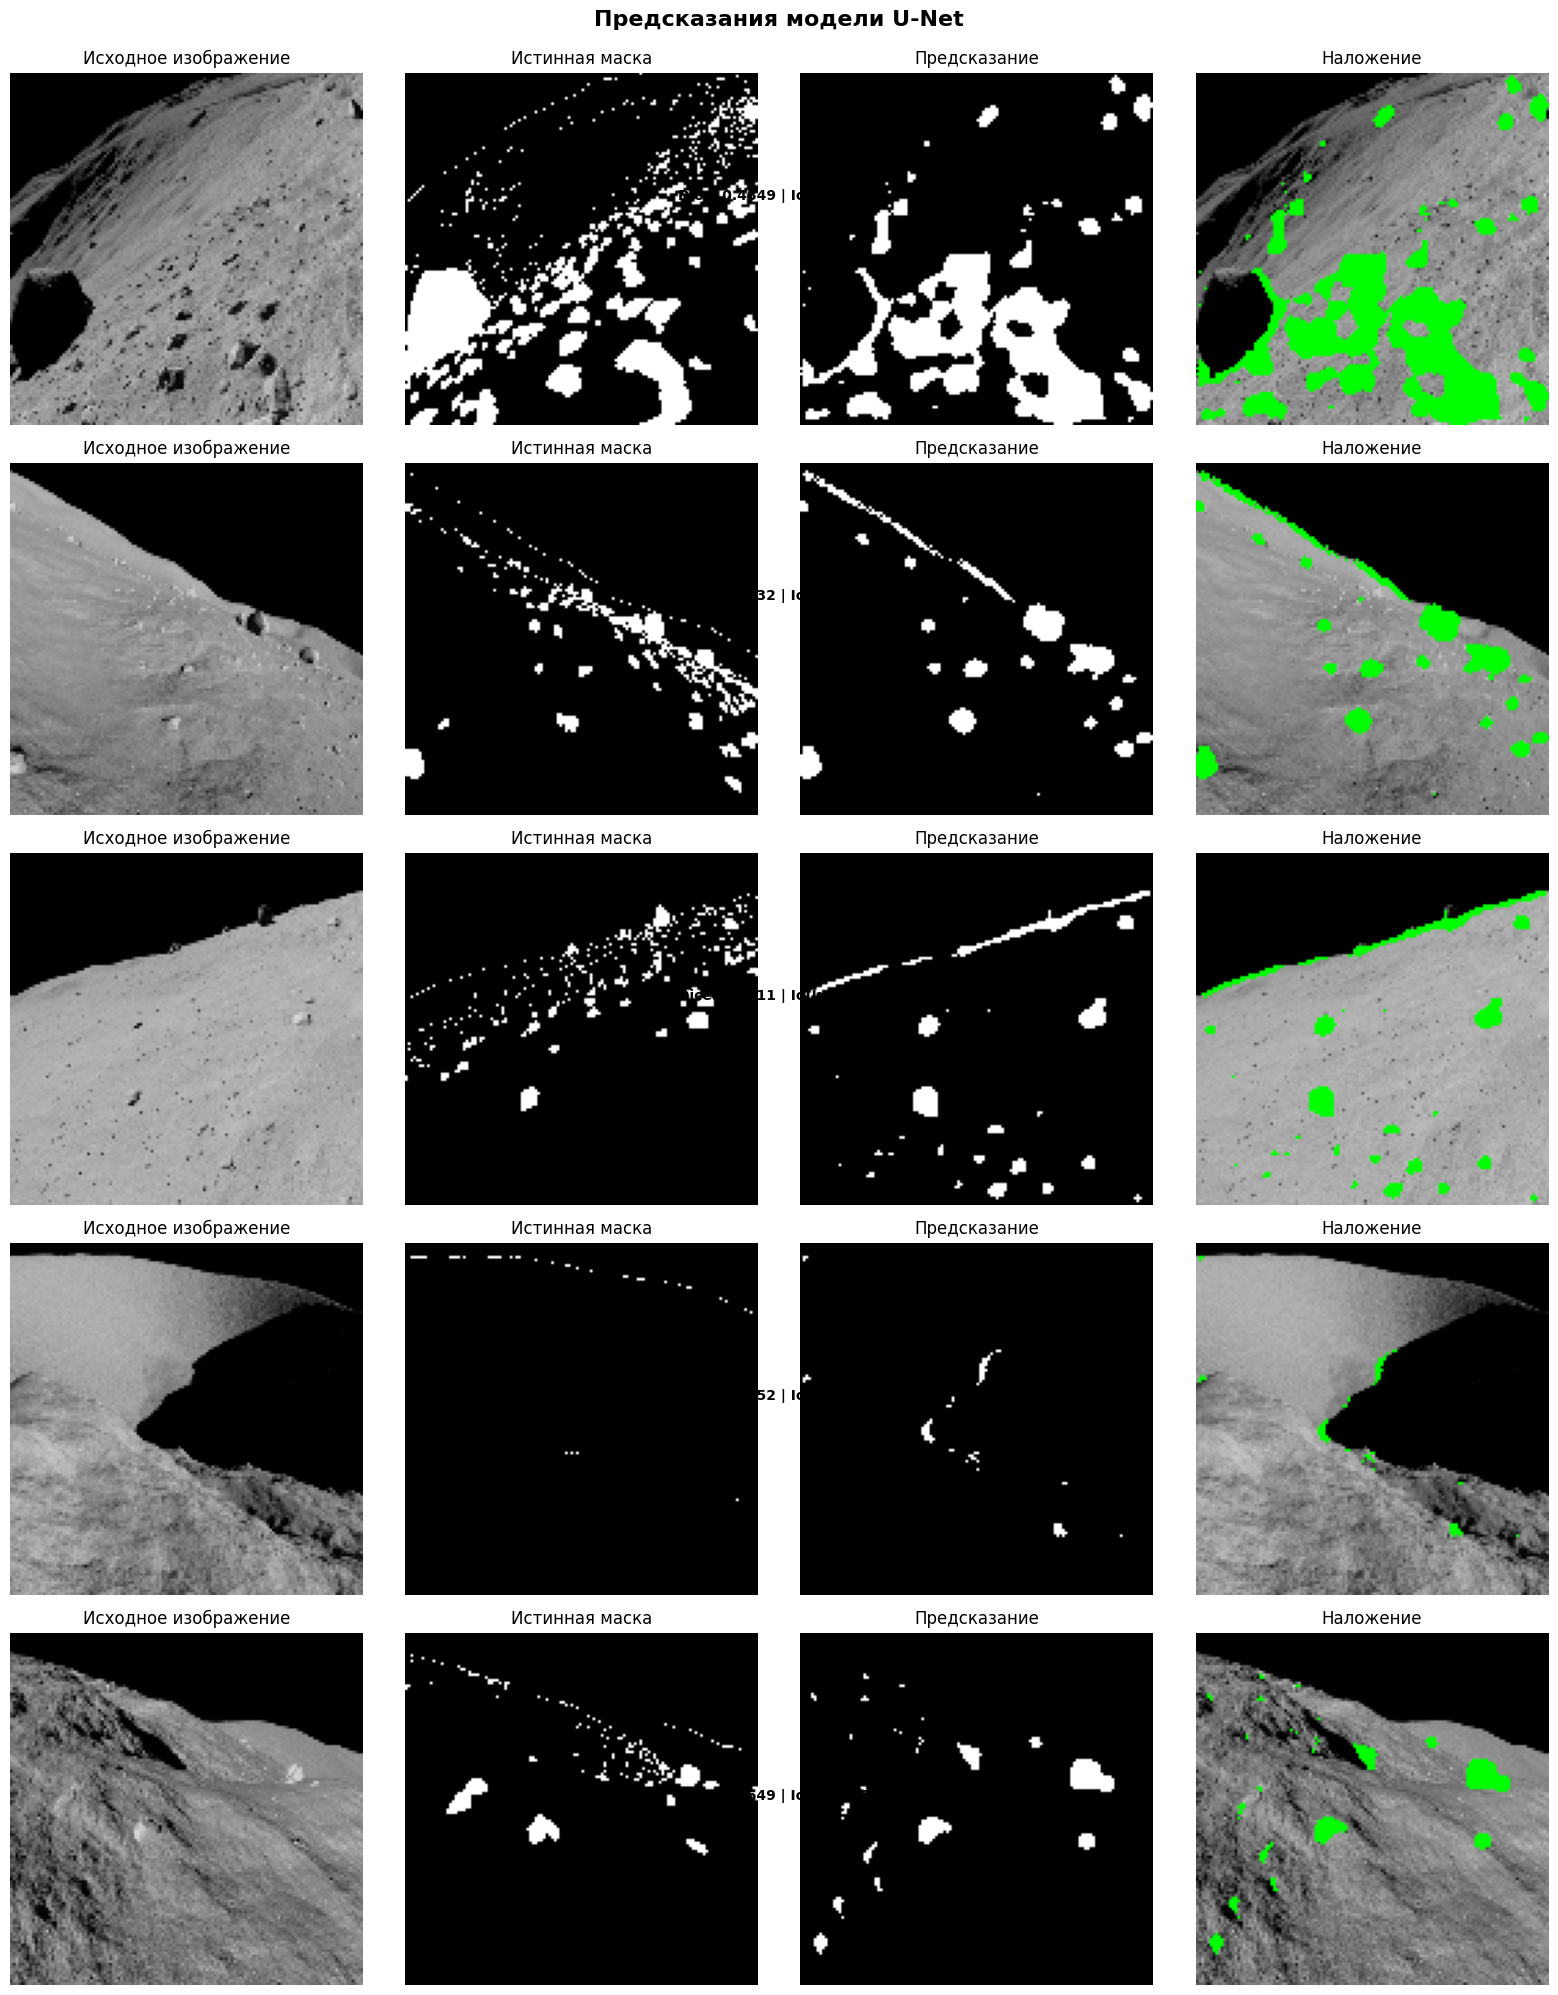

In [27]:
model = UNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

best_checkpoint = torch.load('training_results/2.Segmentation/Baseline/best_moon_unet.pth')


model.load_state_dict( best_checkpoint['model_state_dict'])

print(f"Эпоха: {best_checkpoint['epoch'] + 1}")
print(f"Val Dice: {best_checkpoint['val_dice']:.4f}")
print(f"Val IoU: {best_checkpoint['val_iou']:.4f}")

visualize_predictions(model, val_loader, device, num_samples=5)

# Часть 3.3.  U-Net с бэкбоном из классификатора

In [30]:
from torch import nn
from Model import SimpleNetEncoder

class СusmotUNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[16, 32, 64, 128], pretrained=True):
        super(СusmotUNet, self).__init__()

        m = SimpleNetEncoder()
        if pretrained:
            m.load_state_dict(torch.load('./training_results/1.Classification/SimpleNetEncoder/best_model.pth'))

        self.encoder_blocks = nn.ModuleList([m.stage0, m.stage1, m.stage2, m.stage3 ])
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        


        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):
        
        print(x.shape)
        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)

            skip_connections.append(x)
            #x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)

            x = self.decoder_blocks[idx + 1](x)
        output = self.final_conv(x)
        
        return output


c_unetmodel = СusmotUNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])

test_input = torch.randn(1, 3, 128, 128)
test_output = c_unetmodel(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 1,682,177
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
torch.Size([1, 3, 128, 128])
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


# Эксперименты 
- Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.  

- Вариант B (тонкая настройка): полностью разморозить энкодер на поздних этапах.

In [32]:
c_unetmodel_A = СusmotUNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])
# Разделяем параметры на encoder и decoder
encoder_params = []
decoder_params = []
resnet_criterion = CombinedLoss(bce_weight=0.5, dice_weight=1.25)
for name, param in c_unetmodel_A.named_parameters():
    if 'stage' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

device = torch.device('cpu')
# Encoder обучаем с меньшим LR (fine-tuning), decoder - с обычным
resnet_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 0},  # Меньший LR для предобученных слоев
    {'params': decoder_params, 'lr': 1e-3}   # Обычный LR для новых слоев
])

resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
)

NUM_EPOCHS = 25
SAVE_PATH = './training_results/2.Segmentation/option A/best_simple_unet.pth'

print(f"   Эпох: {NUM_EPOCHS}")
print(f"   Encoder LR: 0 (fine-tuning)")
print(f"   Decoder LR: 1e-3")
print(f"   Модель будет сохранена в: {SAVE_PATH}")
custom_A_history = train_model(
    model=c_unetmodel_A,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=resnet_criterion,
    optimizer=resnet_optimizer,
    scheduler=resnet_scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=SAVE_PATH
)

   Эпох: 20
   Encoder LR: 1e-4 (fine-tuning)
   Decoder LR: 1e-2
   Модель будет сохранена в: ./training_results/2.Segmentation/option A/best_simple_unet.pth
Эпоха 1/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.38s/it, loss=1.4200, dice=0.1353, iou=0.0726]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, loss=1.4082, dice=0.1779, iou=0.0976, acc=0.0978]



 Результаты эпохи 1:
  Train - Loss: 1.4153, Dice: 0.1601, IoU: 0.0872
  Val   - Loss: 1.4082, Dice: 0.1779, IoU: 0.0976, Acc: 0.0978
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.1779
Эпоха 2/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.21s/it, loss=1.3565, dice=0.2469, iou=0.1408]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, loss=1.4049, dice=0.1977, iou=0.1097, acc=0.2621]



 Результаты эпохи 2:
  Train - Loss: 1.3839, Dice: 0.2326, IoU: 0.1317
  Val   - Loss: 1.4049, Dice: 0.1977, IoU: 0.1097, Acc: 0.2621
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.1977
Эпоха 3/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.11s/it, loss=1.3433, dice=0.2845, iou=0.1658]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, loss=1.3976, dice=0.1969, iou=0.1092, acc=0.2701]



 Результаты эпохи 3:
  Train - Loss: 1.3169, Dice: 0.3093, IoU: 0.1832
  Val   - Loss: 1.3976, Dice: 0.1969, IoU: 0.1092, Acc: 0.2701
  LR: 0.000000
Эпоха 4/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.34s/it, loss=1.3109, dice=0.3061, iou=0.1807]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, loss=1.3861, dice=0.1994, iou=0.1107, acc=0.2764]



 Результаты эпохи 4:
  Train - Loss: 1.3260, Dice: 0.3034, IoU: 0.1789
  Val   - Loss: 1.3861, Dice: 0.1994, IoU: 0.1107, Acc: 0.2764
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.1994
Эпоха 5/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.27s/it, loss=1.3057, dice=0.3251, iou=0.1941]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=1.3723, dice=0.2267, iou=0.1279, acc=0.4059]



 Результаты эпохи 5:
  Train - Loss: 1.3123, Dice: 0.3145, IoU: 0.1866
  Val   - Loss: 1.3723, Dice: 0.2267, IoU: 0.1279, Acc: 0.4059
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.2267
Эпоха 6/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.16s/it, loss=1.2942, dice=0.3429, iou=0.2070]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=1.3762, dice=0.2236, iou=0.1259, acc=0.3941]



 Результаты эпохи 6:
  Train - Loss: 1.2775, Dice: 0.3663, IoU: 0.2244
  Val   - Loss: 1.3762, Dice: 0.2236, IoU: 0.1259, Acc: 0.3941
  LR: 0.000000
Эпоха 7/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:03<00:03,  3.97s/it, loss=1.2956, dice=0.3093, iou=0.1830]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, loss=1.3478, dice=0.2667, iou=0.1539, acc=0.5314]



 Результаты эпохи 7:
  Train - Loss: 1.2732, Dice: 0.3436, IoU: 0.2079
  Val   - Loss: 1.3478, Dice: 0.2667, IoU: 0.1539, Acc: 0.5314
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.2667
Эпоха 8/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.56s/it, loss=1.2796, dice=0.3647, iou=0.2230]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, loss=1.3243, dice=0.3275, iou=0.1958, acc=0.6795]



 Результаты эпохи 8:
  Train - Loss: 1.2505, Dice: 0.3825, IoU: 0.2367
  Val   - Loss: 1.3243, Dice: 0.3275, IoU: 0.1958, Acc: 0.6795
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3275
Эпоха 9/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.29s/it, loss=1.2766, dice=0.3591, iou=0.2188]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, loss=1.3127, dice=0.3423, iou=0.2065, acc=0.7113]



 Результаты эпохи 9:
  Train - Loss: 1.2716, Dice: 0.3554, IoU: 0.2161
  Val   - Loss: 1.3127, Dice: 0.3423, IoU: 0.2065, Acc: 0.7113
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3423
Эпоха 10/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.50s/it, loss=1.2645, dice=0.3627, iou=0.2215]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, loss=1.3079, dice=0.3303, iou=0.1978, acc=0.6906]



 Результаты эпохи 10:
  Train - Loss: 1.2684, Dice: 0.3453, IoU: 0.2088
  Val   - Loss: 1.3079, Dice: 0.3303, IoU: 0.1978, Acc: 0.6906
  LR: 0.000000
Эпоха 11/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.25s/it, loss=1.2604, dice=0.3608, iou=0.2201]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, loss=1.3026, dice=0.3254, iou=0.1943, acc=0.6763]



 Результаты эпохи 11:
  Train - Loss: 1.2601, Dice: 0.3744, IoU: 0.2304
  Val   - Loss: 1.3026, Dice: 0.3254, IoU: 0.1943, Acc: 0.6763
  LR: 0.000000
Эпоха 12/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.27s/it, loss=1.2342, dice=0.3872, iou=0.2401]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, loss=1.3016, dice=0.3229, iou=0.1925, acc=0.6688]



 Результаты эпохи 12:
  Train - Loss: 1.2770, Dice: 0.3520, IoU: 0.2142
  Val   - Loss: 1.3016, Dice: 0.3229, IoU: 0.1925, Acc: 0.6688
  LR: 0.000000
Эпоха 13/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.18s/it, loss=1.2550, dice=0.3777, iou=0.2328]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=1.2897, dice=0.3417, iou=0.2060, acc=0.7031]



 Результаты эпохи 13:
  Train - Loss: 1.2363, Dice: 0.4039, IoU: 0.2534
  Val   - Loss: 1.2897, Dice: 0.3417, IoU: 0.2060, Acc: 0.7031
  LR: 0.000000
Эпоха 14/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.24s/it, loss=1.2644, dice=0.3487, iou=0.2112]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=1.2832, dice=0.3498, iou=0.2120, acc=0.7188]



 Результаты эпохи 14:
  Train - Loss: 1.2277, Dice: 0.3864, IoU: 0.2401
  Val   - Loss: 1.2832, Dice: 0.3498, IoU: 0.2120, Acc: 0.7188
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3498
Эпоха 15/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.08s/it, loss=1.2572, dice=0.3560, iou=0.2166]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, loss=1.2766, dice=0.3541, iou=0.2152, acc=0.7272]



 Результаты эпохи 15:
  Train - Loss: 1.2329, Dice: 0.3839, IoU: 0.2379
  Val   - Loss: 1.2766, Dice: 0.3541, IoU: 0.2152, Acc: 0.7272
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3541
Эпоха 16/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.38s/it, loss=1.2472, dice=0.3670, iou=0.2247]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=1.2701, dice=0.3602, iou=0.2197, acc=0.7334]



 Результаты эпохи 16:
  Train - Loss: 1.2480, Dice: 0.3661, IoU: 0.2241
  Val   - Loss: 1.2701, Dice: 0.3602, IoU: 0.2197, Acc: 0.7334
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3602
Эпоха 17/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.14s/it, loss=1.2506, dice=0.3633, iou=0.2220]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=1.2685, dice=0.3606, iou=0.2200, acc=0.7293]



 Результаты эпохи 17:
  Train - Loss: 1.2169, Dice: 0.3956, IoU: 0.2470
  Val   - Loss: 1.2685, Dice: 0.3606, IoU: 0.2200, Acc: 0.7293
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3606
Эпоха 18/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.29s/it, loss=1.2568, dice=0.3580, iou=0.2180]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=1.2758, dice=0.3535, iou=0.2147, acc=0.7109]



 Результаты эпохи 18:
  Train - Loss: 1.2167, Dice: 0.4023, IoU: 0.2528
  Val   - Loss: 1.2758, Dice: 0.3535, IoU: 0.2147, Acc: 0.7109
  LR: 0.000000
Эпоха 19/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:03<00:03,  3.95s/it, loss=1.2342, dice=0.3949, iou=0.2460]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, loss=1.3128, dice=0.3272, iou=0.1956, acc=0.6570]



 Результаты эпохи 19:
  Train - Loss: 1.2194, Dice: 0.3979, IoU: 0.2484
  Val   - Loss: 1.3128, Dice: 0.3272, IoU: 0.1956, Acc: 0.6570
  LR: 0.000000
Эпоха 20/20


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:03<00:03,  3.88s/it, loss=1.2221, dice=0.3967, iou=0.2475]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, loss=1.3152, dice=0.3266, iou=0.1952, acc=0.6551]


 Результаты эпохи 20:
  Train - Loss: 1.2198, Dice: 0.4053, IoU: 0.2542
  Val   - Loss: 1.3152, Dice: 0.3266, IoU: 0.1952, Acc: 0.6551
  LR: 0.000000
Лучший Val Dice: 0.3606


torch.Size([20, 3, 128, 128])


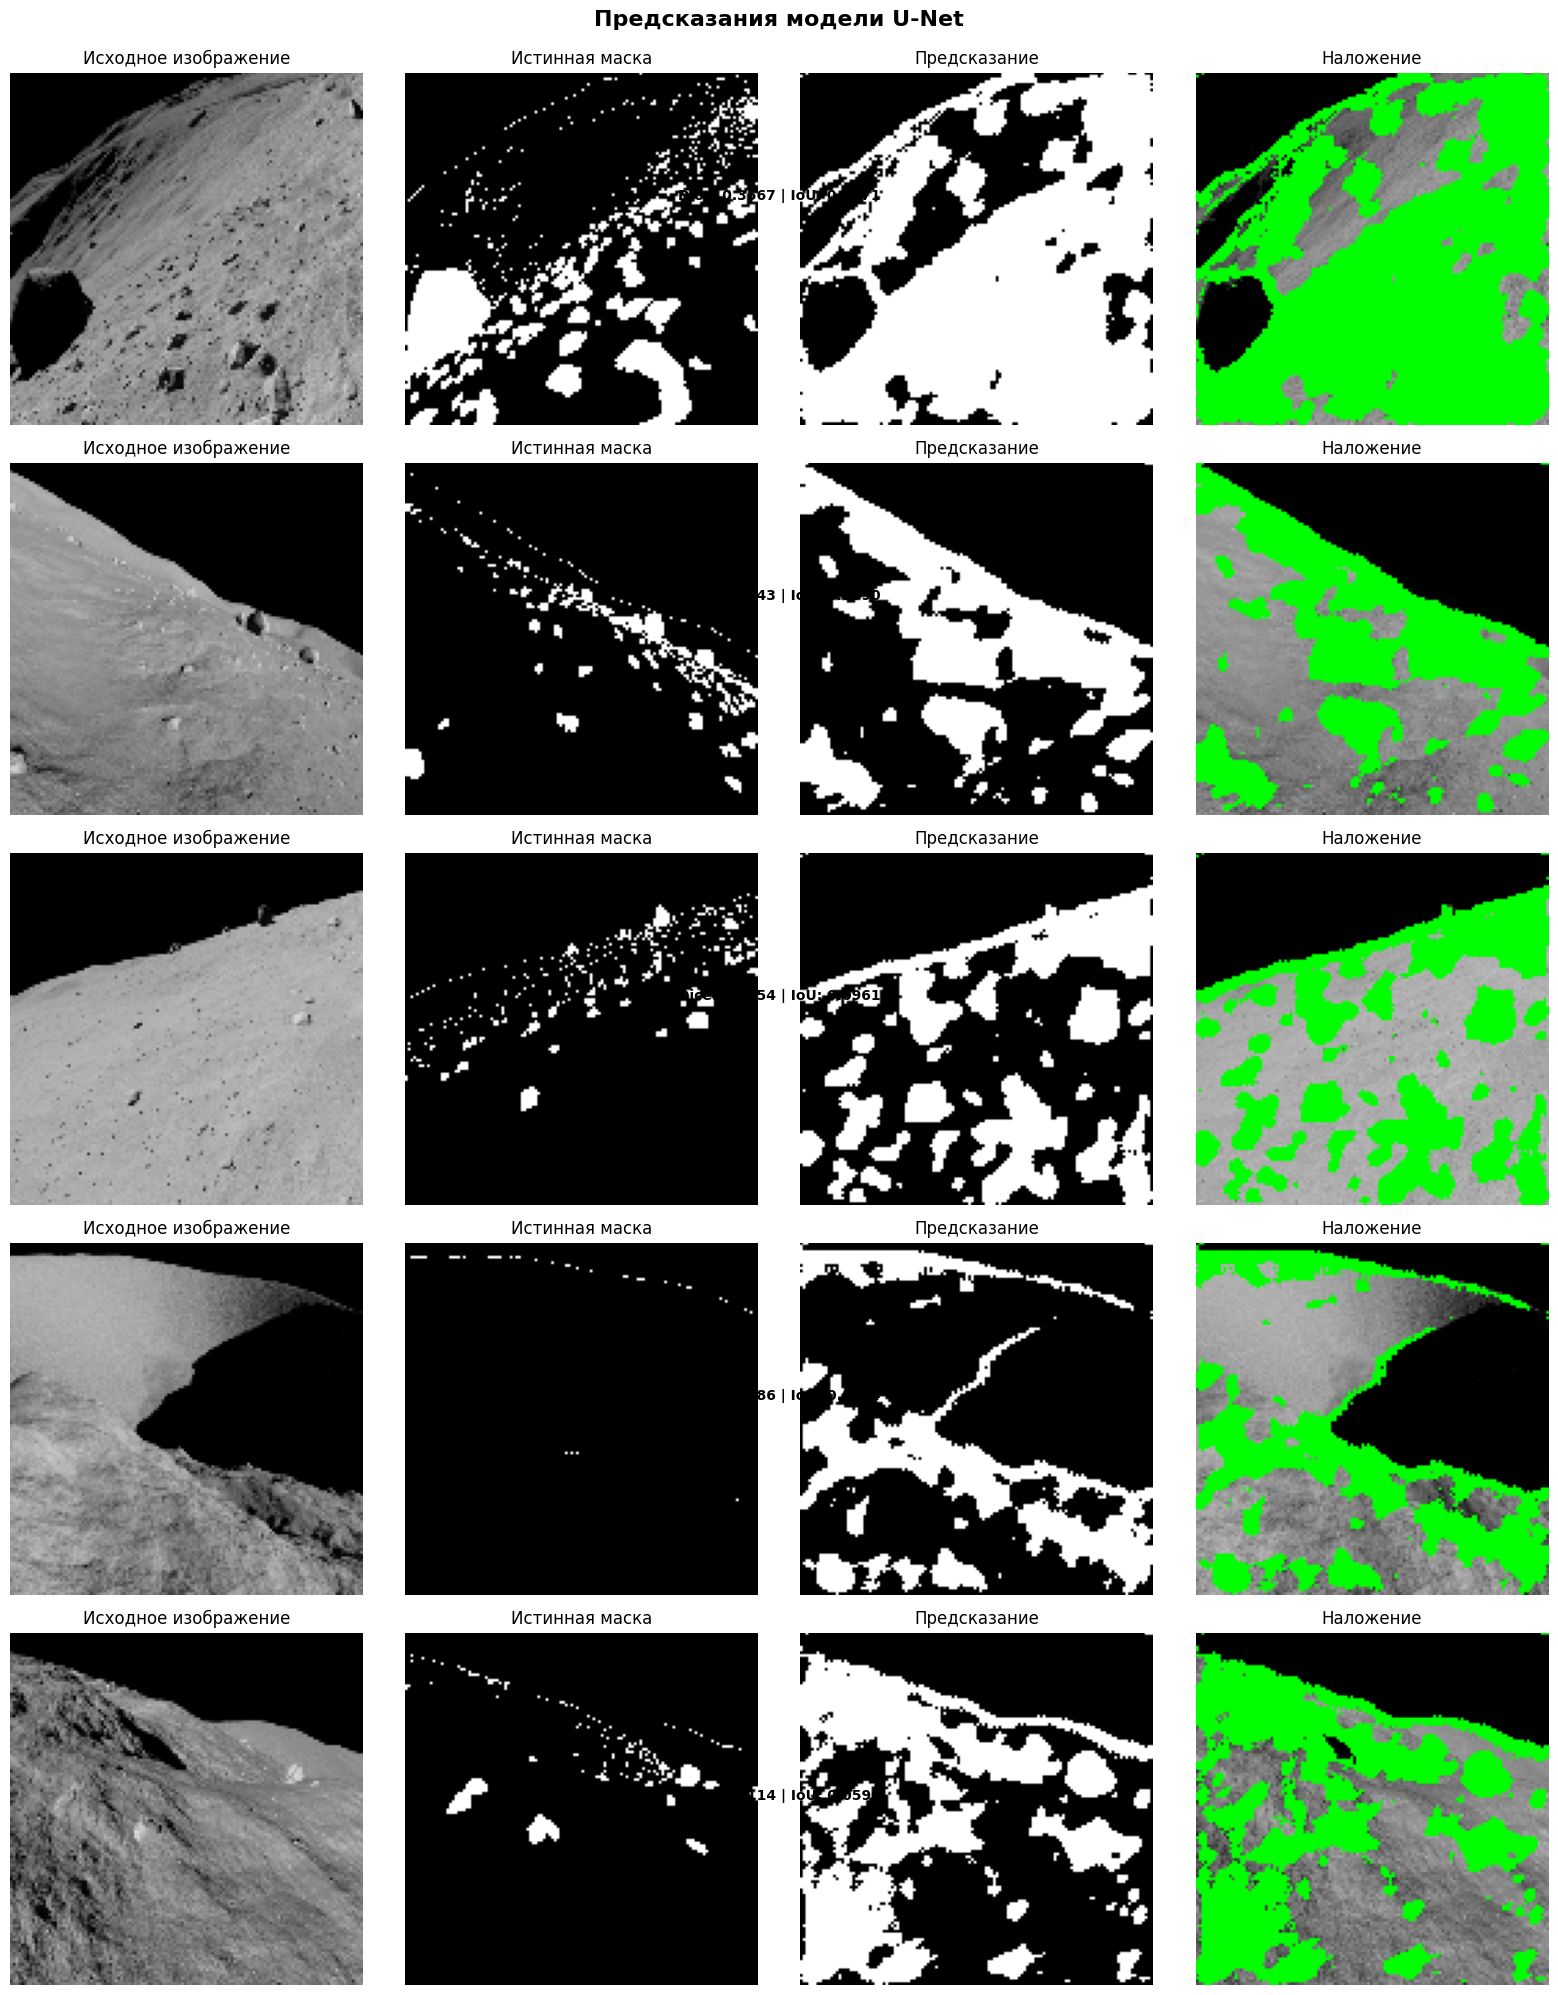

In [76]:
visualize_predictions(c_unetmodel_A, val_loader, device, num_samples=5)

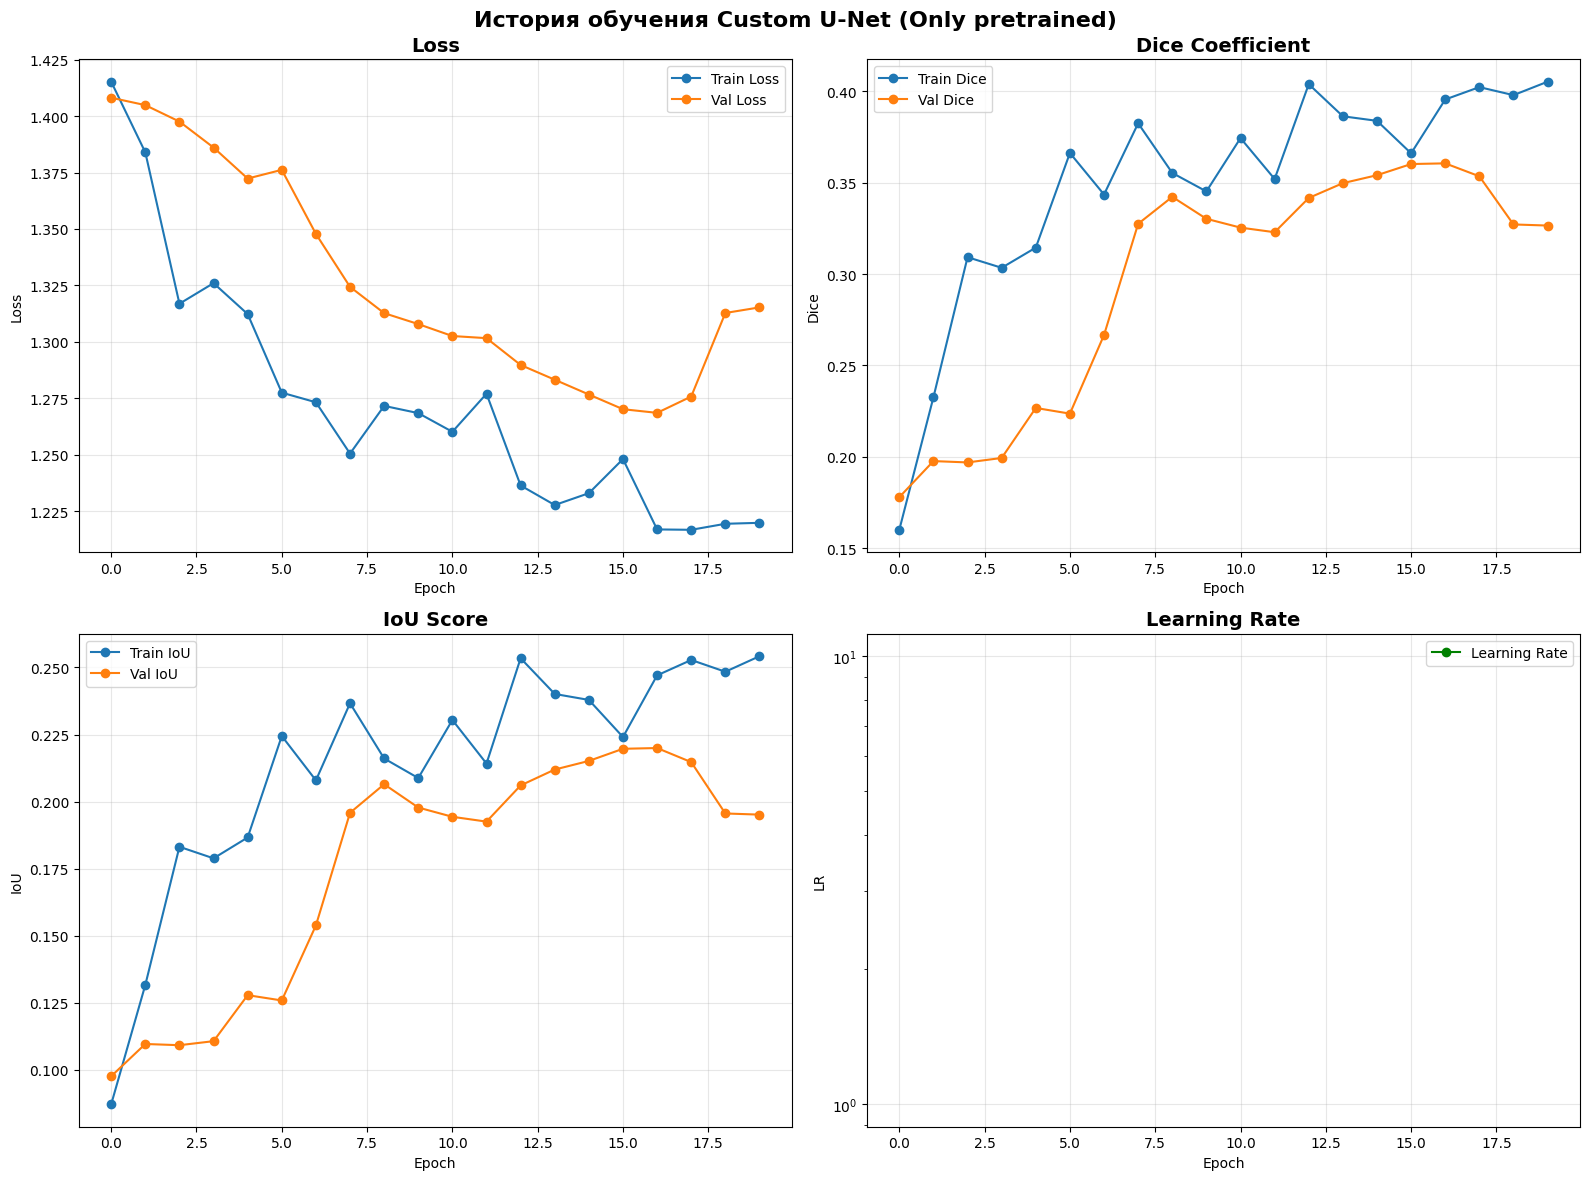

Сохранено в ./training_results/2.Segmentation/option A
Train Loss: 1.2198
Val Loss: 1.3152
Train Dice: 0.4053
Val Dice: 0.3266
Train IoU: 0.2542
Val IoU: 0.1952
Val Accuracy: 0.6551


In [35]:
plot_training_history(custom_A_history, save_path='./training_results/2.Segmentation/option A',model_name='Custom U-Net (Only pretrained)')

# Вариант Б - заморозить до поздних этапов


In [39]:

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler_freeze, scheduler_plateau, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        scheduler_freeze.step()

        if scheduler_plateau is not None:
            scheduler_plateau.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history

In [72]:
c_unetmodel_B = СusmotUNet(in_channels=3, out_channels=1, features=[16, 32, 64, 128])
from torch.optim.lr_scheduler import LambdaLR


# Разделяем параметры на encoder и decoder
encoder_params = []
decoder_params = []
resnet_criterion = CombinedLoss(bce_weight = 0.5, dice_weight= 1.25)
for name, param in c_unetmodel_B.named_parameters():
    if 'stage' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

device = torch.device('cpu')
# Encoder обучаем с меньшим LR (fine-tuning), decoder - с обычным
resnet_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-12},  # Меньший LR для предобученных слоев
    {'params': decoder_params, 'lr': 1e-4}   # Обычный LR для новых слоев
])



scheduler_freeze = LambdaLR(resnet_optimizer, lr_lambda=[lambda x: 0 if x < 11 else 1e+6, lambda x: 1.0])

scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer, 
    mode='min', 
    factor = 0.6, 
    patience = 6, 
)
scheduler_plateau = None

NUM_EPOCHS = 25
SAVE_PATH = './training_results/2.Segmentation/option B/best_simple_unet.pth'

print(f"   Эпох: {NUM_EPOCHS}")
print(f"   Encoder LR: 1e-12 (fine-tuning)")
print(f"   Decoder LR: 1e-4")
print(f"   Модель будет сохранена в: {SAVE_PATH}")
custom_B_history = train_model(
    model=c_unetmodel_B,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=resnet_criterion,
    optimizer=resnet_optimizer,
    scheduler_freeze=scheduler_freeze,
    scheduler_plateau=scheduler_plateau,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_path=SAVE_PATH
)

Параметров: 1,682,177
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
   Эпох: 25
   Encoder LR: 1e-4 (fine-tuning)
   Decoder LR: 1e-2
   Модель будет сохранена в: ./training_results/2.Segmentation/option B/best_simple_unet.pth
Эпоха 1/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.38s/it, loss=0.5529, dice=0.2189, iou=0.1229]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, loss=0.5138, dice=0.0000, iou=0.0000, acc=0.9023]



 Результаты эпохи 1:
  Train - Loss: 0.5510, Dice: 0.2093, IoU: 0.1169
  Val   - Loss: 0.5138, Dice: 0.0000, IoU: 0.0000, Acc: 0.9023
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.0000
Эпоха 2/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.32s/it, loss=0.5322, dice=0.2864, iou=0.1671]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=0.5115, dice=0.0001, iou=0.0000, acc=0.9023]



 Результаты эпохи 2:
  Train - Loss: 0.5334, Dice: 0.2628, IoU: 0.1515
  Val   - Loss: 0.5115, Dice: 0.0001, IoU: 0.0000, Acc: 0.9023
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.0001
Эпоха 3/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.25s/it, loss=0.5202, dice=0.3060, iou=0.1807]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=0.5089, dice=0.0310, iou=0.0157, acc=0.9015]



 Результаты эпохи 3:
  Train - Loss: 0.5257, Dice: 0.2819, IoU: 0.1643
  Val   - Loss: 0.5089, Dice: 0.0310, IoU: 0.0157, Acc: 0.9015
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.0310
Эпоха 4/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.05s/it, loss=0.5163, dice=0.3001, iou=0.1765]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.5059, dice=0.1767, iou=0.0969, acc=0.8982]



 Результаты эпохи 4:
  Train - Loss: 0.5121, Dice: 0.2972, IoU: 0.1745
  Val   - Loss: 0.5059, Dice: 0.1767, IoU: 0.0969, Acc: 0.8982
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.1767
Эпоха 5/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.87s/it, loss=0.5048, dice=0.3088, iou=0.1826]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.5029, dice=0.2987, iou=0.1756, acc=0.8915]



 Результаты эпохи 5:
  Train - Loss: 0.5045, Dice: 0.2923, IoU: 0.1713
  Val   - Loss: 0.5029, Dice: 0.2987, IoU: 0.1756, Acc: 0.8915
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.2987
Эпоха 6/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.37s/it, loss=0.4947, dice=0.3194, iou=0.1901]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, loss=0.5047, dice=0.3182, iou=0.1892, acc=0.8476]



 Результаты эпохи 6:
  Train - Loss: 0.4964, Dice: 0.2908, IoU: 0.1704
  Val   - Loss: 0.5047, Dice: 0.3182, IoU: 0.1892, Acc: 0.8476
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3182
Эпоха 7/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.10s/it, loss=0.4916, dice=0.3125, iou=0.1852]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s, loss=0.5257, dice=0.2908, iou=0.1701, acc=0.7291]



 Результаты эпохи 7:
  Train - Loss: 0.4919, Dice: 0.2781, IoU: 0.1620
  Val   - Loss: 0.5257, Dice: 0.2908, IoU: 0.1701, Acc: 0.7291
  LR: 0.000000
Эпоха 8/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.06s/it, loss=0.4818, dice=0.2993, iou=0.1760]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=0.4927, dice=0.2718, iou=0.1572, acc=0.8730]



 Результаты эпохи 8:
  Train - Loss: 0.4872, Dice: 0.2687, IoU: 0.1555
  Val   - Loss: 0.4927, Dice: 0.2718, IoU: 0.1572, Acc: 0.8730
  LR: 0.000000
Эпоха 9/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:03<00:03,  3.92s/it, loss=0.4773, dice=0.3364, iou=0.2022]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=0.4957, dice=0.1911, iou=0.1056, acc=0.8765]



 Результаты эпохи 9:
  Train - Loss: 0.4774, Dice: 0.3063, IoU: 0.1812
  Val   - Loss: 0.4957, Dice: 0.1911, IoU: 0.1056, Acc: 0.8765
  LR: 0.000000
Эпоха 10/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.69s/it, loss=0.4747, dice=0.3036, iou=0.1790]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.4902, dice=0.2094, iou=0.1169, acc=0.8773]



 Результаты эпохи 10:
  Train - Loss: 0.4722, Dice: 0.2936, IoU: 0.1721
  Val   - Loss: 0.4902, Dice: 0.2094, IoU: 0.1169, Acc: 0.8773
  LR: 0.000000
Эпоха 11/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:05<00:05,  5.59s/it, loss=0.4694, dice=0.3173, iou=0.1886]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s, loss=0.6175, dice=0.2765, iou=0.1604, acc=0.7403]



 Результаты эпохи 11:
  Train - Loss: 0.4732, Dice: 0.2761, IoU: 0.1608
  Val   - Loss: 0.6175, Dice: 0.2765, IoU: 0.1604, Acc: 0.7403
  LR: 0.000000
Эпоха 12/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.83s/it, loss=0.4693, dice=0.2811, iou=0.1635]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, loss=0.6527, dice=0.3399, iou=0.2047, acc=0.7733]



 Результаты эпохи 12:
  Train - Loss: 0.4681, Dice: 0.2725, IoU: 0.1578
  Val   - Loss: 0.6527, Dice: 0.3399, IoU: 0.2047, Acc: 0.7733
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3399
Эпоха 13/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.64s/it, loss=0.4668, dice=0.2735, iou=0.1584]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, loss=0.5649, dice=0.3432, iou=0.2071, acc=0.8140]



 Результаты эпохи 13:
  Train - Loss: 0.4626, Dice: 0.2829, IoU: 0.1648
  Val   - Loss: 0.5649, Dice: 0.3432, IoU: 0.2071, Acc: 0.8140
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3432
Эпоха 14/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.29s/it, loss=0.4633, dice=0.2754, iou=0.1597]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s, loss=0.5022, dice=0.3739, iou=0.2300, acc=0.8594]



 Результаты эпохи 14:
  Train - Loss: 0.4605, Dice: 0.2927, IoU: 0.1716
  Val   - Loss: 0.5022, Dice: 0.3739, IoU: 0.2300, Acc: 0.8594
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3739
Эпоха 15/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.13s/it, loss=0.4609, dice=0.2793, iou=0.1623]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=0.4939, dice=0.3928, iou=0.2444, acc=0.8682]



 Результаты эпохи 15:
  Train - Loss: 0.4596, Dice: 0.2965, IoU: 0.1742
  Val   - Loss: 0.4939, Dice: 0.3928, IoU: 0.2444, Acc: 0.8682
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3928
Эпоха 16/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.55s/it, loss=0.4545, dice=0.3257, iou=0.1945]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.4919, dice=0.3941, iou=0.2454, acc=0.8622]



 Результаты эпохи 16:
  Train - Loss: 0.4569, Dice: 0.3095, IoU: 0.1832
  Val   - Loss: 0.4919, Dice: 0.3941, IoU: 0.2454, Acc: 0.8622
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.3941
Эпоха 17/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:05<00:05,  5.17s/it, loss=0.4546, dice=0.3192, iou=0.1899]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, loss=0.4771, dice=0.3940, iou=0.2454, acc=0.8755]



 Результаты эпохи 17:
  Train - Loss: 0.4557, Dice: 0.3131, IoU: 0.1856
  Val   - Loss: 0.4771, Dice: 0.3940, IoU: 0.2454, Acc: 0.8755
  LR: 0.000000
Эпоха 18/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.23s/it, loss=0.4514, dice=0.3328, iou=0.1996]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=0.4624, dice=0.2914, iou=0.1706, acc=0.8959]



 Результаты эпохи 18:
  Train - Loss: 0.4531, Dice: 0.3293, IoU: 0.1971
  Val   - Loss: 0.4624, Dice: 0.2914, IoU: 0.1706, Acc: 0.8959
  LR: 0.000000
Эпоха 19/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.19s/it, loss=0.4484, dice=0.3309, iou=0.1983]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, loss=0.4658, dice=0.3166, iou=0.1881, acc=0.8890]



 Результаты эпохи 19:
  Train - Loss: 0.4492, Dice: 0.3283, IoU: 0.1964
  Val   - Loss: 0.4658, Dice: 0.3166, IoU: 0.1881, Acc: 0.8890
  LR: 0.000000
Эпоха 20/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.08s/it, loss=0.4467, dice=0.3125, iou=0.1852]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, loss=0.4803, dice=0.3794, iou=0.2341, acc=0.8645]



 Результаты эпохи 20:
  Train - Loss: 0.4473, Dice: 0.3085, IoU: 0.1824
  Val   - Loss: 0.4803, Dice: 0.3794, IoU: 0.2341, Acc: 0.8645
  LR: 0.000000
Эпоха 21/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.10s/it, loss=0.4423, dice=0.3431, iou=0.2071]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, loss=0.4937, dice=0.3827, iou=0.2366, acc=0.8416]



 Результаты эпохи 21:
  Train - Loss: 0.4394, Dice: 0.3827, IoU: 0.2374
  Val   - Loss: 0.4937, Dice: 0.3827, IoU: 0.2366, Acc: 0.8416
  LR: 0.000000
Эпоха 22/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.05s/it, loss=0.4402, dice=0.3538, iou=0.2149]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, loss=0.4842, dice=0.3855, iou=0.2387, acc=0.8443]



 Результаты эпохи 22:
  Train - Loss: 0.4403, Dice: 0.3687, IoU: 0.2261
  Val   - Loss: 0.4842, Dice: 0.3855, IoU: 0.2387, Acc: 0.8443
  LR: 0.000000
Эпоха 23/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.02s/it, loss=0.4376, dice=0.3945, iou=0.2457]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, loss=0.4668, dice=0.4022, iou=0.2517, acc=0.8640]



 Результаты эпохи 23:
  Train - Loss: 0.4402, Dice: 0.3549, IoU: 0.2164
  Val   - Loss: 0.4668, Dice: 0.4022, IoU: 0.2517, Acc: 0.8640
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4022
Эпоха 24/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:04<00:04,  4.23s/it, loss=0.4359, dice=0.3874, iou=0.2402]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, loss=0.4537, dice=0.4125, iou=0.2598, acc=0.8848]



 Результаты эпохи 24:
  Train - Loss: 0.4355, Dice: 0.3670, IoU: 0.2249
  Val   - Loss: 0.4537, Dice: 0.4125, IoU: 0.2598, Acc: 0.8848
  LR: 0.000000
  Сохранена лучшая модель! Dice: 0.4125
Эпоха 25/25


Training:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64, 3, 128, 128])


Training:  50%|█████     | 1/2 [00:05<00:05,  5.16s/it, loss=0.4339, dice=0.3871, iou=0.2400]

torch.Size([16, 3, 128, 128])


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20, 3, 128, 128])


Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, loss=0.4612, dice=0.4110, iou=0.2586, acc=0.8640]


 Результаты эпохи 25:
  Train - Loss: 0.4348, Dice: 0.3721, IoU: 0.2287
  Val   - Loss: 0.4612, Dice: 0.4110, IoU: 0.2586, Acc: 0.8640
  LR: 0.000000
Лучший Val Dice: 0.4125


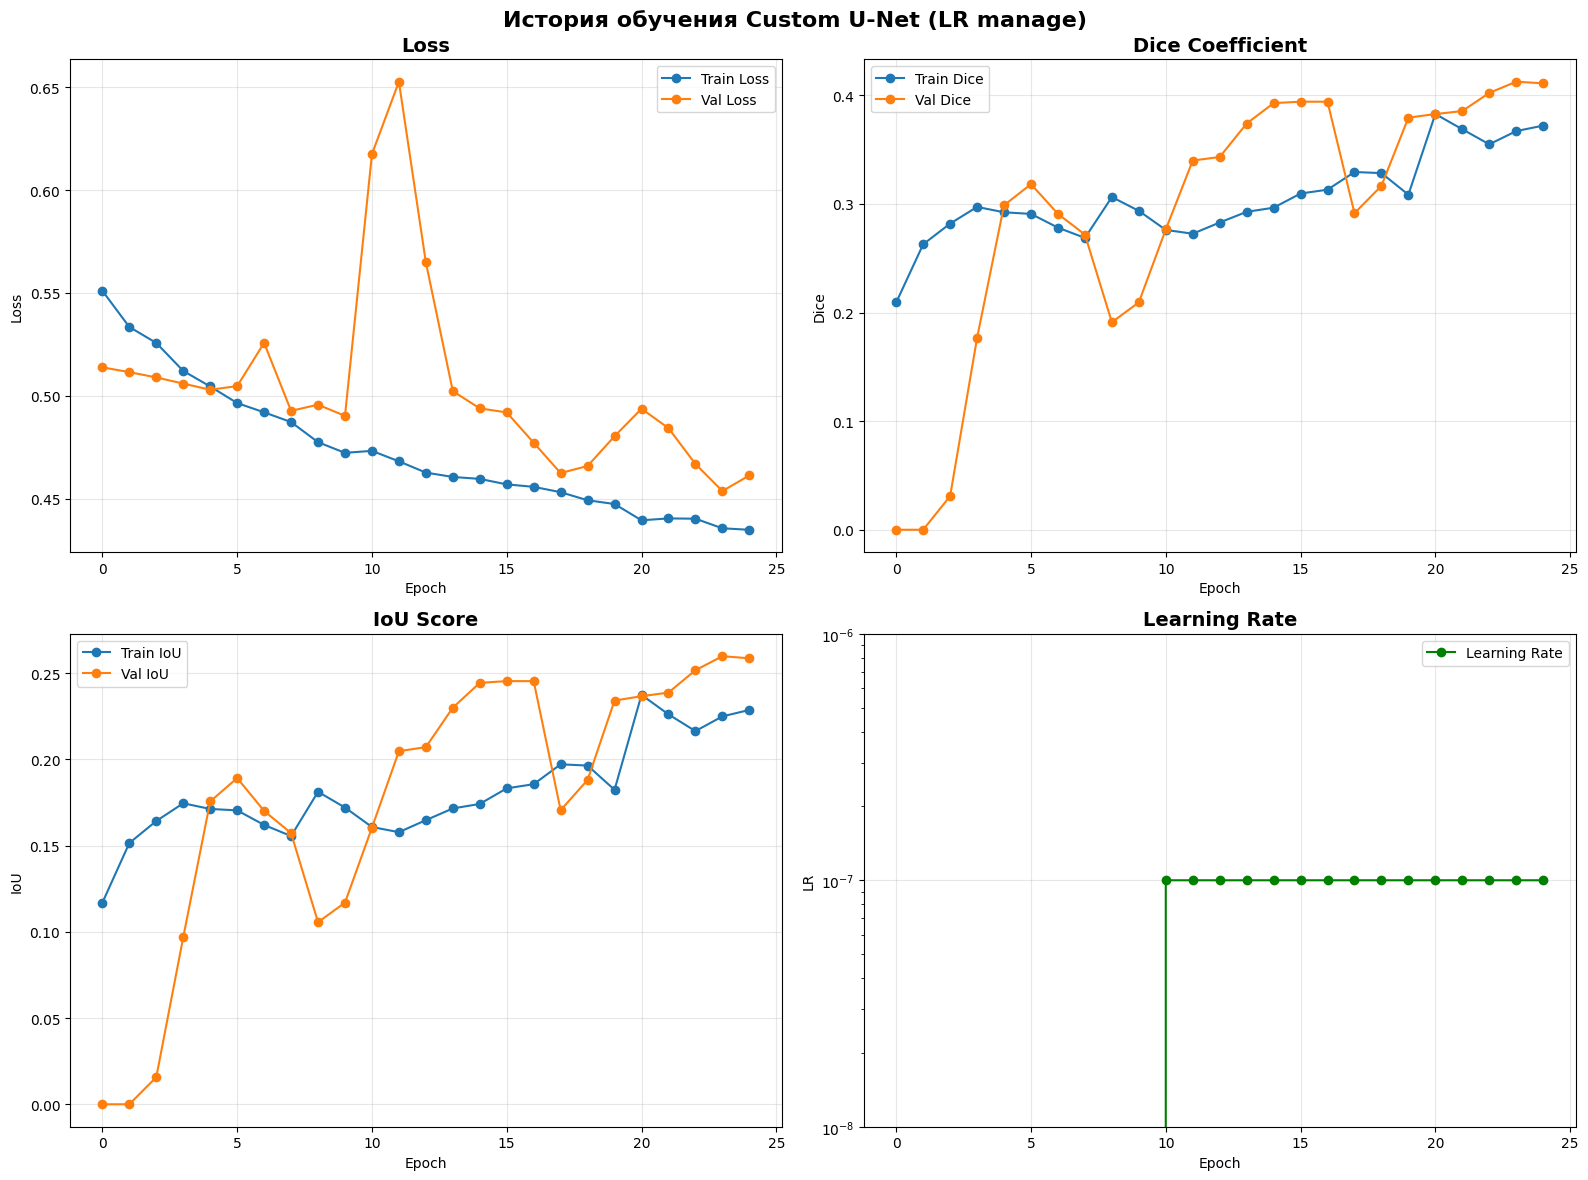

Сохранено в ./training_results/2.Segmentation/option B
Train Loss: 0.4348
Val Loss: 0.4612
Train Dice: 0.3721
Val Dice: 0.4110
Train IoU: 0.2287
Val IoU: 0.2586
Val Accuracy: 0.8640


In [74]:
plot_training_history(custom_B_history, 
                      save_path='./training_results/2.Segmentation/option B',model_name='Custom U-Net (LR manage)')

torch.Size([20, 3, 128, 128])


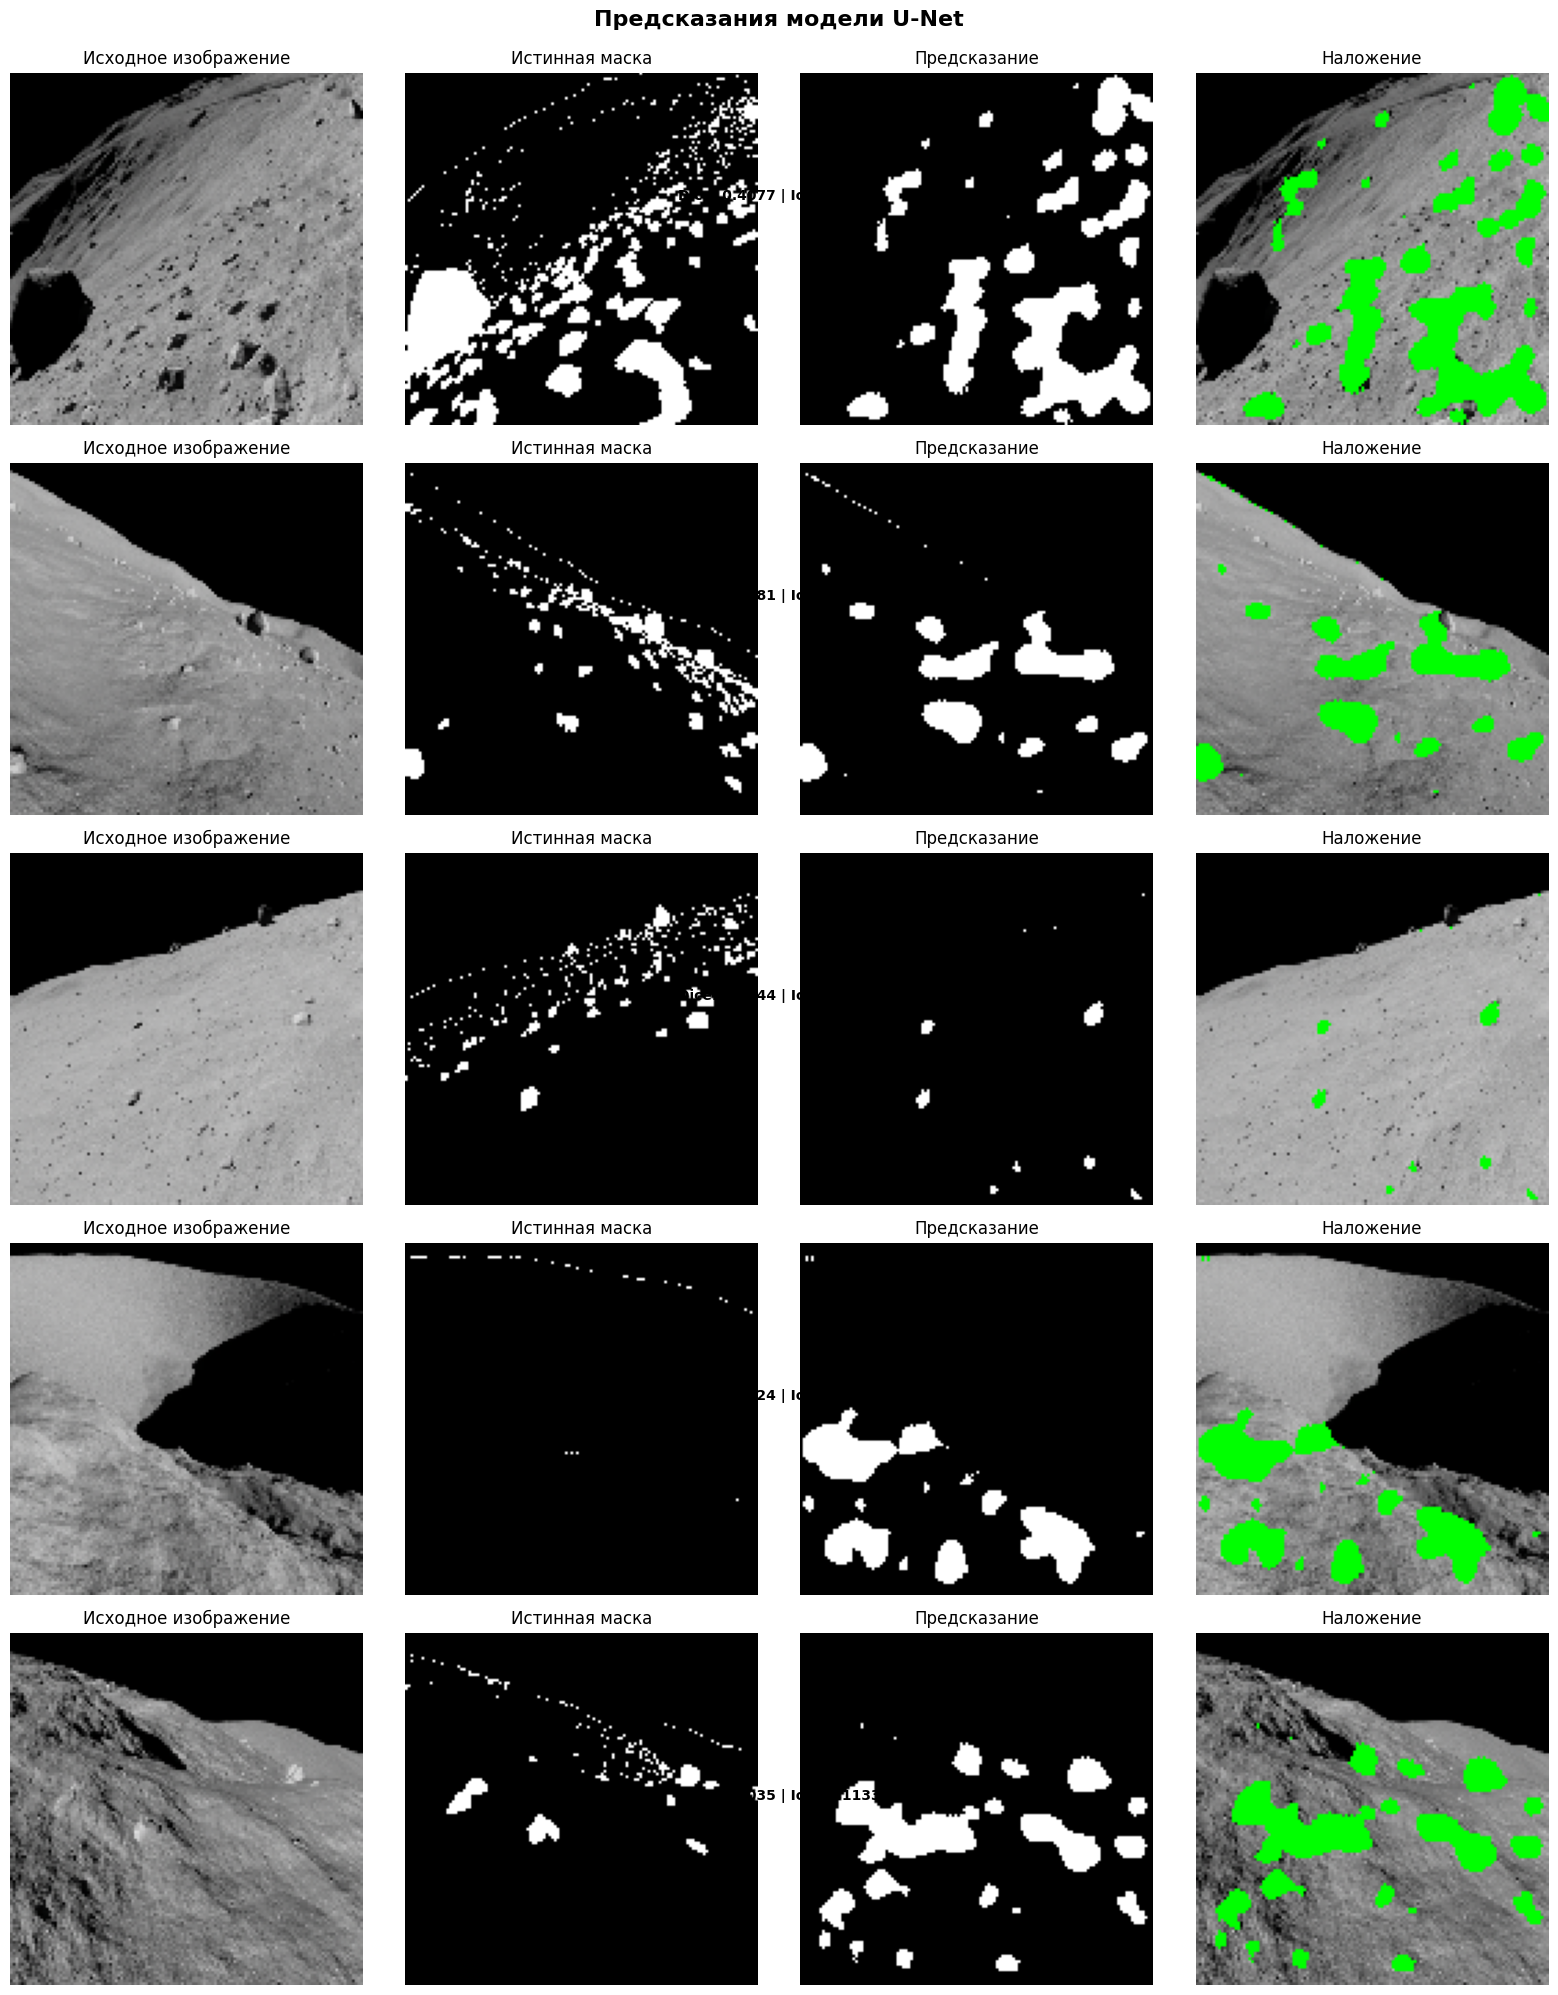

In [78]:
visualize_predictions(c_unetmodel_B, val_loader, device, num_samples=5)